In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cvxopt

import pickle

# Variable saving.


def pickleSave(var, filename='.pickle'):
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(var, f)
    print('PickleSave Succeeded.')
    return

# Variable loading.


def pickleLoad(filename):
    """
    Make sure it's assigned to a variable.
    """
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'rb') as f:
        cache = pickle.load(f)
    print("PickleLoad Succeeded. Make sure it's assigned to a variable.")
    return cache


In [3]:
X = pickleLoad('X')

PickleLoad Succeeded. Make sure it's assigned to a variable.


In [41]:
XHat_pR_IRLSPKS = pickleLoad('XHat_pR_IRLSPKS.pickle')
XHat_pR_ModCS = pickleLoad('XHat_pR_ModCS.pickle')

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


In [10]:
Means = pickleLoad('Means.pickle')

PickleLoad Succeeded. Make sure it's assigned to a variable.


In [5]:
sampMats = pickleLoad('sampMats.pickle')
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
Supps = pickleLoad('Supps.pickle')

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


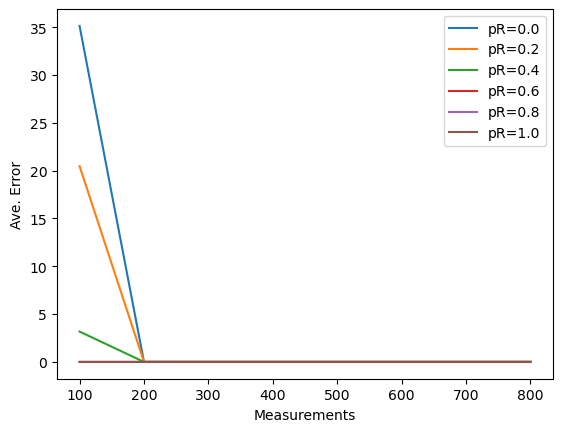

In [44]:
errFig = []
for p in range(6):
    XHat_m = XHat_pR_IRLSPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

numMeasurements = np.arange(100,801,100)
priorRatios = [0.,0.2,0.4,0.6,0.8,1.]
for p in range(6):
    plt.plot(numMeasurements,errFig[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
# plt.ylim(0,1e-5)
plt.show()

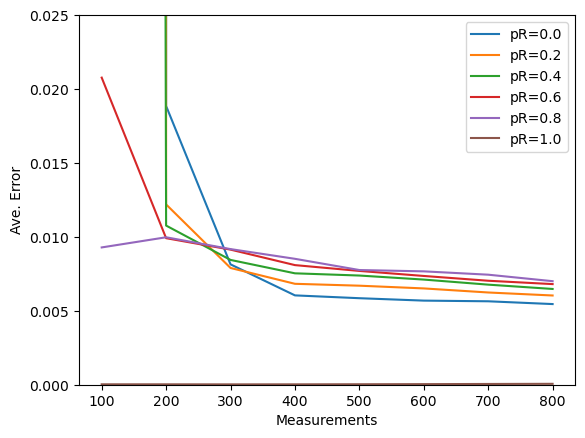

In [16]:
errFig = []
for p in range(6):
    XHat_m = XHat_pR_ModCS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.ylim(0,0.025)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


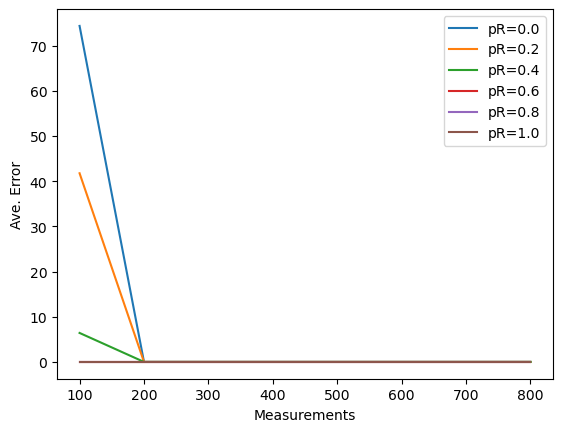

In [18]:
XHat_pR_CosampPKS = pickleLoad('XHat_pR_CosampPKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_CosampPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
# plt.ylim(0,0.025)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


C:\Users\xndliu\AppData\Local\Temp\ipykernel_20544\3658349410.py:8: RuntimeWarning: overflow encountered in square
  err.append(np.sum((XHat - X)**2)/20)


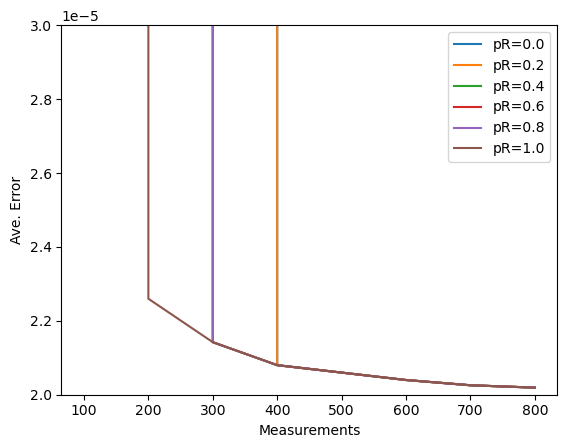

In [35]:
XHat_pR_IHTPKS = pickleLoad('XHat_pR_IHTPKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_IHTPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
plt.ylim(2e-5,3e-5)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


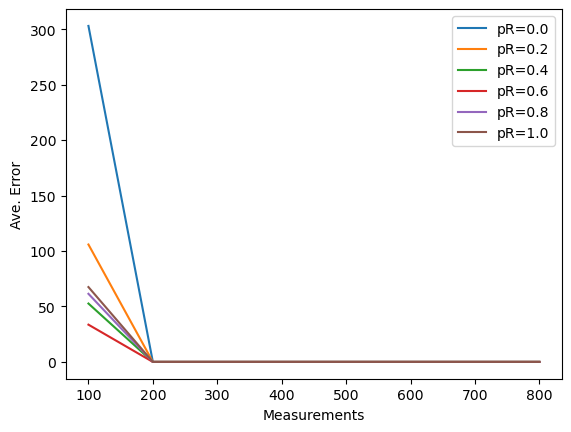

In [37]:
XHat_pR_OMPPKS = pickleLoad('XHat_pR_OMPPKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_OMPPKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
# plt.ylim(2e-5,3e-5)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


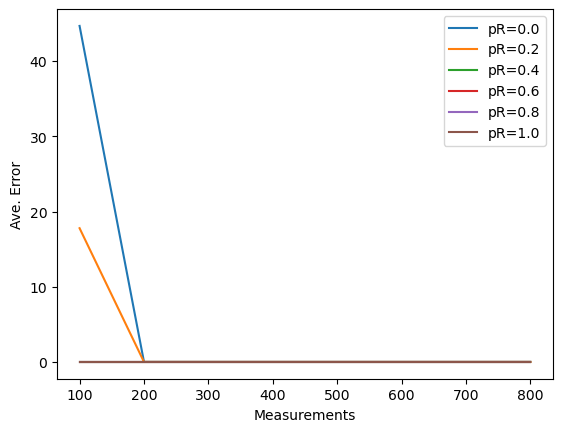

In [38]:
XHat_pR_RWLSSl0PKS = pickleLoad('XHat_pR_RWLSSl0PKS.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_RWLSSl0PKS[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
# plt.ylim(2e-5,3e-5)
plt.show()

In [40]:
XHat_pR_weightedl1 = pickleLoad('XHat_pR_weightedl1.pickle')
errFig = []
for p in range(6):
    XHat_m = XHat_pR_weightedl1[p]
    err = []
    for m in range(len(XHat_m)):
        XHat = XHat_m[m]
        err.append(np.sum((XHat - X)**2)/20)
    errFig.append(err)

for p in range(6):
    plt.plot(numMeasurements,errFig[p],label='pR='+str(priorRatios[p]))
plt.legend()
plt.xlabel('Measurements')
plt.ylabel('Ave. Error')
# plt.ylim(2e-5,3e-5)
plt.show()

PickleLoad Succeeded. Make sure it's assigned to a variable.


ValueError: operands could not be broadcast together with shapes (1000,30) (2000,20) 